In [1]:
import os
import keras
from keras.models import  Sequential
from keras.layers import LSTM, GRU, Dense, Activation, Dropout
from keras.callbacks import EarlyStopping

import pandas as pd

from pandas import HDFStore
import numpy as np


Using Theano backend.


In [2]:
data_dir = "data/"


In [47]:
hdf = HDFStore(data_dir + "data_15_stores.hd5")
hdf_full = HDFStore(data_dir + "data_full_stores.hd5")
test_store = hdf['store_data']['Store'].iloc[-1]
print("test store: %d" % test_store)

# CompetitionOpenSinceMonth and CompetitionOpenSinceYear have the same missing data
# 
print("\nStore data columns:\n")
for column in hdf_full['store_data'].columns.values:
    print("%30s: %d values missing" % (column, len(hdf_full['store_data'].loc[hdf_full['store_data'][column].isnull()])))

#print('\nStore data columns:\n\n' + '\n'.join(hdf['store_data'].columns.values))
#print(hdf['store_data'].loc[hdf['store_data']['Promo2SinceWeek'].isnull()])

print(len(hdf['store_data']))

test store: 1113

Store data columns:

                         Store: 0 values missing
                     StoreType: 0 values missing
                    Assortment: 0 values missing
           CompetitionDistance: 3 values missing
     CompetitionOpenSinceMonth: 354 values missing
      CompetitionOpenSinceYear: 354 values missing
                        Promo2: 0 values missing
               Promo2SinceWeek: 544 values missing
               Promo2SinceYear: 544 values missing
                 PromoInterval: 544 values missing
                     MeanSales: 0 values missing
                      StdSales: 0 values missing
             MeanSalesOpenOnly: 0 values missing
              StdSalesOpenOnly: 0 values missing
                 MeanCustomers: 0 values missing
                  StdCustomers: 0 values missing
         MeanCustomersOpenOnly: 0 values missing
          StdCustomersOpenOnly: 0 values missing
16


In [4]:
store_data = hdf['store_data']
#mean = store_data['CompetitionDistance'].mean()
#std = store_data['CompetitionDistance'].std()
#store_data['CompetitionDistance'] = (store_data['CompetitionDistance'] - mean) / std
store_data.loc[store_data['Promo2WeeksSinceJoined'].isnull(), 'Promo2WeeksSinceJoined'] = 0.0
store_data.loc[store_data['CompetitionMonthsSinceOpen'].isnull(), 'CompetitionMonthsSinceOpen'] = 0.0
print(store_data[['Promo2', 'StoreNorm', 'Promo2WeeksSinceJoined', 'CompetitionMonthsSinceOpen']])
#print(hdf['train_data'][['Date', 'Store', 'SalesNorm']])

#print(hdf['common_info'])

      Promo2  StoreNorm  Promo2WeeksSinceJoined  CompetitionMonthsSinceOpen
44         0  -1.476723               -0.526845                   -0.297569
110        1  -1.296297                2.335515                   -0.754967
135        1  -1.227954                1.101286                    0.492483
204        0  -1.039327               -0.526845                    1.240953
306        0  -0.760487               -0.526845                    2.550775
319        0  -0.724949               -0.526845                    0.055875
462        0  -0.334027               -0.526845                   -0.754967
493        0  -0.249281               -0.526845                    0.367738
740        0   0.425948               -0.526845                   -0.754967
785        1   0.548966                0.794918                    1.511234
815        0   0.630977               -0.526845                   -0.754967
853        1   0.734859                2.090420                   -0.754967
904        0

In [5]:
#print(hdf['test_data'].loc[hdf['test_data']['Store'] == test_store])#.loc[hdf['test_data']['StateHoliday'] != 0])

print('Test data columns:\n')
for column in hdf['test_data'].columns.values:
    print("%30s: %d values missing" % (column, len(hdf['test_data'].loc[hdf['test_data'][column].isnull()])))

Test data columns:

                            Id: 0 values missing
                         Store: 0 values missing
                     DayOfWeek: 0 values missing
                          Date: 0 values missing
                          Open: 0 values missing
                         Promo: 0 values missing
                  StateHoliday: 0 values missing
                 SchoolHoliday: 0 values missing
                    WeekOfYear: 0 values missing


In [6]:
#print(hdf['train_data'][['Date', 'WeekOfYear']].loc[hdf['train_data']['Store'] == test_store])
print('Train data columns:\n')
for column in hdf['train_data'].columns.values:
    print("%30s: %d values missing" % (column, len(hdf['train_data'].loc[hdf['train_data'][column].isnull()])))
#print(hdf['train_data']['SalesNormOpenOnly'].loc[hdf['train_data']['SalesNormOpenOnly'] < 0.0])

Train data columns:

                         Store: 0 values missing
                     DayOfWeek: 0 values missing
                          Date: 0 values missing
                         Sales: 0 values missing
                     Customers: 0 values missing
                          Open: 0 values missing
                         Promo: 0 values missing
                  StateHoliday: 0 values missing
                 SchoolHoliday: 0 values missing
                     SalesNorm: 0 values missing
             SalesNormOpenOnly: 0 values missing
                 CustomersNorm: 0 values missing
         CustomersNormOpenOnly: 0 values missing
                    WeekOfYear: 0 values missing
                          Year: 0 values missing
Series([], Name: SalesNormOpenOnly, dtype: float32)


In [7]:
"""
- Would store data be part of the RNN model since it's not time-dependent? How to incorporate time-dependent and time-independent inputs?
- Should we eliminate closed days completely? (probably yes since kinda trivial but maybe test both)
- WeekOfYear?
- enable statefulness?
- train with multiple subjects?
- What does output_dim mean exactly?

"""
stores = store_data['Store'].unique()
input_features = ['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'WeekOfYear', 'Year']
output_features_openonly = ['SalesNormOpenOnly', 'CustomersNormOpenOnly']
output_features = ['SalesNorm', 'CustomersNorm']
store_features = ['StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionMonthsSinceOpen',
                  'Promo2', 'Promo2WeeksSinceJoined', 'StoreNorm']

train_features_full = ['SalesNorm', 'CustomersNorm', 'Open', 'DayOfWeek',
                       'Promo', 'StateHoliday', 'SchoolHoliday', 'WeekOfYear']

inputs_open_only = hdf['train_data'][input_features]\
                       .loc[hdf['train_data']['Store'] == test_store]\
                       .loc[hdf['train_data']['Open'] != 0]\
                       .as_matrix()

outputs_open_only = hdf['train_data'][output_features_openonly]\
                       .loc[hdf['train_data']['Store'] == test_store]\
                       .loc[hdf['train_data']['Open'] != 0]\
                       .as_matrix()

store_inputs = hdf['store_data'][store_features]\
                   .loc[hdf['store_data']['Store'] == test_store]\
                   .as_matrix()

#print(np.append(np.repeat(store_inputs, 3, axis=0), inputs_open_only[:3], axis=1))

inputs_open_only = inputs_open_only.reshape(inputs_open_only.shape + (1,))
#outputs_open_only_train = outputs_open_only_train.reshape(outputs_open_only_train.shape + (1,))
#inputs_open_only_test = inputs_open_only.reshape(inputs_open_only_test.shape + (1,))
#outputs_open_only_test = outputs_open_only_test.reshape(outputs_open_only_test.shape + (1,))

#print(inputs_open_only.shape[1:])
#print(len(inputs_open_only_train[0]))
#print(hdf['train_data'].loc[hdf['train_data']['Store'] == test_store])#.loc[hdf['train_data']['StateHoliday'] != 0])


In [50]:
# Predicting SalesNorm and CustomersNorm
model_nostore_openonly = Sequential()
model_nostore_openonly.add(LSTM(output_dim=365, return_sequences=False,# activation='relu',
                                input_shape=(len(input_features) + len(store_features), 1)))
model_nostore_openonly.add(Dropout(0.2))

#model.add(LSTM(365, return_sequences=False))
#model.add(Dropout(0.2))

model_nostore_openonly.add(Dense(2))
model_nostore_openonly.add(Activation('sigmoid'))

model_nostore_openonly.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])

In [51]:
batch_size = 32
for store in np.random.permutation(stores)[:]:
    train_inputs = hdf['train_data'][input_features]\
                       .loc[hdf['train_data']['Store'] == store]\
                       .as_matrix()
    
    store_inputs = hdf['store_data'][store_features]\
                       .loc[hdf['store_data']['Store'] == store]\
                       .as_matrix()

    train_inputs = np.append(np.repeat(store_inputs, len(train_inputs), axis=0),
                             train_inputs, axis=1)

    train_inputs = train_inputs.reshape(train_inputs.shape + (1,))

    train_outputs = hdf['train_data'][output_features]\
                           .loc[hdf['train_data']['Store'] == store]\
                           .as_matrix()
    print('\n\nStore: ' + str(store) + '\n')
    history = model_nostore_openonly.fit(train_inputs, train_outputs, batch_size=batch_size, nb_epoch=5,
                                     #callbacks=[early_stopping],
                                     validation_split=0.2)



Store: 136

Train on 606 samples, validate on 152 samples
Epoch 1/5
606/606 [==============================] - 21s - loss: 0.0112 - acc: 0.8779 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 2/5
606/606 [==============================] - 20s - loss: 0.0056 - acc: 0.9076 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 3/5
606/606 [==============================] - 21s - loss: 0.0055 - acc: 0.9142 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 4/5
606/606 [==============================] - 20s - loss: 0.0053 - acc: 0.9505 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 5/5
606/606 [==============================] - 20s - loss: 0.0051 - acc: 0.9637 - val_loss: 0.0038 - val_acc: 1.0000


Store: 111

Train on 753 samples, validate on 189 samples
Epoch 1/5
753/753 [==============================] - 25s - loss: 0.0075 - acc: 0.8911 - val_loss: 0.0073 - val_acc: 1.0000
Epoch 2/5
753/753 [==============================] - 25s - loss: 0.0069 - acc: 0.9203 - val_loss: 0.0067 - val_acc: 1.0000
Epoch 3/5
753/753 [

In [82]:
train_inputs = hdf['train_data'][input_features]\
                   .loc[hdf['train_data']['Store'] == 1022]\
                   .as_matrix()

store_inputs = hdf['store_data'][store_features]\
                   .loc[hdf['store_data']['Store'] == 1022]\
                   .as_matrix()

train_inputs = np.append(np.repeat(store_inputs, len(train_inputs), axis=0),
                         train_inputs, axis=1)

train_inputs = train_inputs.reshape(train_inputs.shape + (1,))

train_outputs = hdf['train_data'][output_features]\
                       .loc[hdf['train_data']['Store'] == 1022]\
                       .as_matrix()
print('\n\nStore: ' + str(45) + '\n')
history = model_nostore_openonly.fit(train_inputs[:753], train_outputs[:753], batch_size=batch_size, nb_epoch=10)
predictions = model_nostore_openonly.predict(train_inputs[753:])
#print(predictions)
#print(train_outputs[753:])



Store: 45

Epoch 1/10
753/753 [==============================] - 23s - loss: 0.0047 - acc: 0.6308    
Epoch 2/10
753/753 [==============================] - 23s - loss: 0.0019 - acc: 0.7105    
Epoch 3/10
753/753 [==============================] - 23s - loss: 0.0011 - acc: 0.7437    
Epoch 4/10
753/753 [==============================] - 23s - loss: 0.0021 - acc: 0.7105    
Epoch 5/10
753/753 [==============================] - 23s - loss: 0.0011 - acc: 0.7238    
Epoch 6/10
753/753 [==============================] - 23s - loss: 0.0015 - acc: 0.7397    
Epoch 7/10
753/753 [==============================] - 23s - loss: 0.0011 - acc: 0.7158    
Epoch 8/10
753/753 [==============================] - 23s - loss: 0.0012 - acc: 0.7171    
Epoch 9/10
753/753 [==============================] - 24s - loss: 9.5787e-04 - acc: 0.7131    
Epoch 10/10
753/753 [==============================] - 23s - loss: 0.0011 - acc: 0.7092    
[[ 0.22909227  0.23445423]
 [ 0.00354141  0.00299461]
 [ 0.41579384  0.3

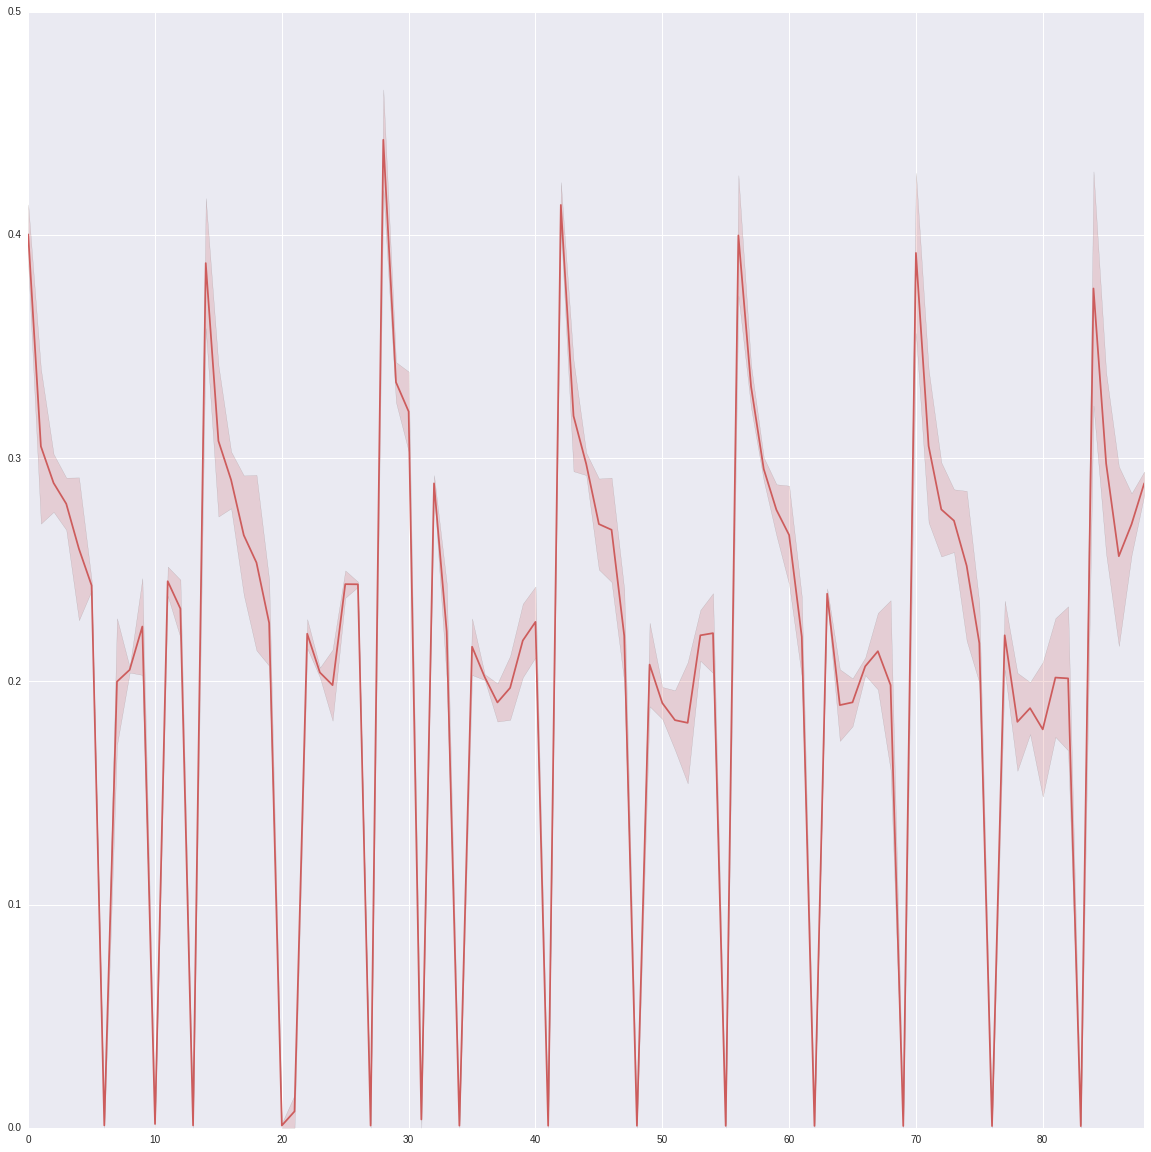

In [83]:
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

# plot_df = pd.DataFrame({'Prediction_Sales' : predictions[:, 0],
#                         'Prediction_Customers' : predictions[:, 1],
#                         'Actual_Sales' : train_outputs[753:][:, 0],
#                         'Actual_Customers' : train_outputs[753:][:, 1]})
plt.figure(figsize=(20, 20))
sns.tsplot([train_outputs[853:][:, 0], predictions[100:, 0]], color="indianred")
#print(predictions[:, 0])


In [98]:
from keras.utils.visualize_util import plot
plot(model_nostore_openonly, to_file='model.png')

In [84]:
loss, accuracy = model_nostore_openonly.evaluate(train_inputs, train_outputs, verbose=True)
print('loss: ', loss)
print('accuracy: ', accuracy)
print()

942/942 [==============================] - 7s     
loss:  0.00123653406843
accuracy:  0.681528662167



In [16]:
batch_size = 32
train_inputs = hdf['train_data'][input_features]\
                   .loc[hdf['train_data']['Store'] == test_store]\
                   .as_matrix()
    
store_inputs = hdf['store_data'][store_features]\
                   .loc[hdf['store_data']['Store'] == test_store]\
                   .as_matrix()
train_inputs = train_inputs.reshape(train_inputs.shape + (1,))

train_outputs = hdf['train_data'][output_features]\
                   .loc[hdf['train_data']['Store'] == test_store]\
                   .as_matrix()
#early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history = model_nostore_openonly.fit(train_inputs, train_outputs, batch_size=batch_size, nb_epoch=50,
                                     #callbacks=[early_stopping],
                                     validation_split=0.2)

Train on 753 samples, validate on 189 samples
Epoch 1/50


ValueError: total size of new array must be unchanged
Apply node that caused the error: Reshape{3}(Elemwise{Add}[(0, 0)].0, TensorConstant{[ -1  13 365]})
Toposort index: 81
Inputs types: [TensorType(float32, matrix), TensorType(int64, vector)]
Inputs shapes: [(192, 365), (3,)]
Inputs strides: [(1460, 4), (8,)]
Inputs values: ['not shown', array([ -1,  13, 365])]
Outputs clients: [[Join(TensorConstant{2}, Reshape{3}.0, Reshape{3}.0, Reshape{3}.0, Reshape{3}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/usr/local/lib/python3.4/dist-packages/keras/engine/topology.py", line 341, in create_input_layer
    self(x)
  File "/usr/local/lib/python3.4/dist-packages/keras/engine/topology.py", line 485, in __call__
    self.add_inbound_node(inbound_layers, node_indices, tensor_indices)
  File "/usr/local/lib/python3.4/dist-packages/keras/engine/topology.py", line 543, in add_inbound_node
    Node.create_node(self, inbound_layers, node_indices, tensor_indices)
  File "/usr/local/lib/python3.4/dist-packages/keras/engine/topology.py", line 148, in create_node
    output_tensors = to_list(outbound_layer.call(input_tensors[0], mask=input_masks[0]))
  File "/usr/local/lib/python3.4/dist-packages/keras/layers/recurrent.py", line 227, in call
    preprocessed_input = self.preprocess_input(x)
  File "/usr/local/lib/python3.4/dist-packages/keras/layers/recurrent.py", line 775, in preprocess_input
    input_dim, self.output_dim, timesteps)
  File "/usr/local/lib/python3.4/dist-packages/keras/layers/recurrent.py", line 38, in time_distributed_dense
    x = K.reshape(x, (-1, timesteps, output_dim))
  File "/usr/local/lib/python3.4/dist-packages/keras/backend/theano_backend.py", line 287, in reshape
    return T.reshape(x, shape)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [53]:
model_dir = "models"

yaml_string = model_nostore_openonly.to_yaml()
model_file_path = os.path.join(model_dir, 'model_storedata_15stores_mse_1layer_dropout.yaml')
open(model_file_path, 'w').write(yaml_string)

weight_file_path = os.path.join(model_dir, 'model_storedata_15stores_mse_1layer_dropout_weights.hd5')
model_nostore_openonly.save_weights(weight_file_path, overwrite=True)

In [ ]:
#print(history.history)